In [1]:
#simple lstm with loopback from keras to try

In [63]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
np.random.seed(1337)

In [64]:
uber = pd.read_csv('../uber_data.csv', parse_dates=True, index_col=0)
uber_man = uber[uber['borough'] == 'Manhattan'].dropna().drop(['hday','borough'],axis=1)

In [65]:
uber_man = uber_man[['pickups']]
uber_man

,pickups
pickup_dt,
2015-01-01 01:00:00,5258
2015-01-01 02:00:00,4345
2015-01-01 03:00:00,4577
2015-01-01 04:00:00,3003
2015-01-01 05:00:00,1313
...,...
2015-06-30 19:00:00,4585
2015-06-30 20:00:00,4210
2015-06-30 21:00:00,4313


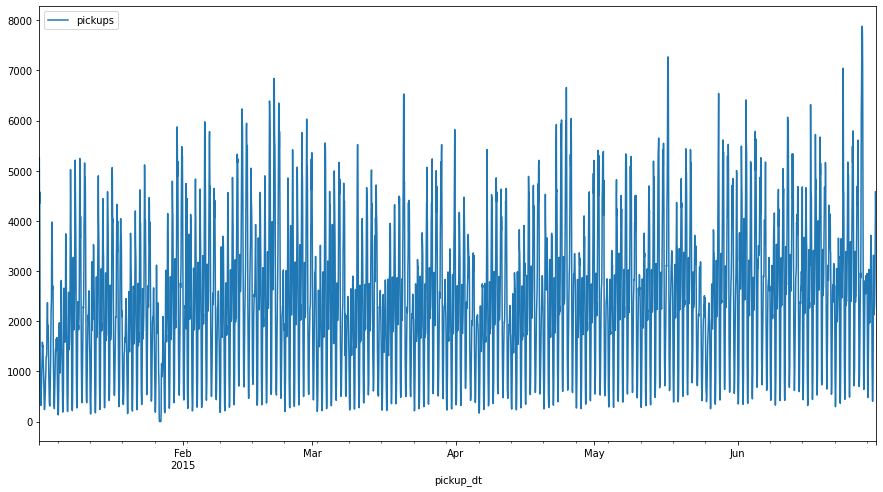

In [66]:
uber_man.plot(figsize = (15,8))

In [67]:
uber_shift = uber_man.copy()

uber_shift['y_t+1'] = uber_shift['pickups'].shift(-1, freq='H')
uber_shift

,pickups,y_t+1
pickup_dt,,
2015-01-01 01:00:00,5258,4345.0
2015-01-01 02:00:00,4345,4577.0
2015-01-01 03:00:00,4577,3003.0
2015-01-01 04:00:00,3003,1313.0
2015-01-01 05:00:00,1313,672.0
...,...,...
2015-06-30 19:00:00,4585,4210.0
2015-06-30 20:00:00,4210,4313.0
2015-06-30 21:00:00,4313,4452.0


In [68]:
for i in [1,2,3,4,24,7*24]:
    uber_shift[f'lag_{i}'] = uber_shift.pickups.shift(i)
    
uber_shift

,pickups,y_t+1,lag_1,lag_2,lag_3,lag_4,lag_24,lag_168
pickup_dt,,,,,,,,
2015-01-01 01:00:00,5258,4345.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00,4345,4577.0,5258.0,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00,4577,3003.0,4345.0,5258.0,NaN,NaN,NaN,NaN
2015-01-01 04:00:00,3003,1313.0,4577.0,4345.0,5258.0,NaN,NaN,NaN
2015-01-01 05:00:00,1313,672.0,3003.0,4577.0,4345.0,5258.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2015-06-30 19:00:00,4585,4210.0,4298.0,3586.0,2929.0,2577.0,3712.0,7046.0
2015-06-30 20:00:00,4210,4313.0,4585.0,4298.0,3586.0,2929.0,3317.0,5747.0
2015-06-30 21:00:00,4313,4452.0,4210.0,4585.0,4298.0,3586.0,3340.0,4634.0


In [69]:
uber_shift = uber_shift.dropna()

In [70]:

uber_shift

,pickups,y_t+1,lag_1,lag_2,lag_3,lag_4,lag_24,lag_168
pickup_dt,,,,,,,,
2015-01-08 01:00:00,739,443.0,1524.0,2664.0,3603.0,3867.0,601.0,5258.0
2015-01-08 02:00:00,443,268.0,739.0,1524.0,2664.0,3603.0,320.0,4345.0
2015-01-08 03:00:00,268,217.0,443.0,739.0,1524.0,2664.0,204.0,4577.0
2015-01-08 04:00:00,217,322.0,268.0,443.0,739.0,1524.0,200.0,3003.0
2015-01-08 05:00:00,322,756.0,217.0,268.0,443.0,739.0,331.0,1313.0
...,...,...,...,...,...,...,...,...
2015-06-30 18:00:00,4298,4585.0,3586.0,2929.0,2577.0,2326.0,3496.0,5683.0
2015-06-30 19:00:00,4585,4210.0,4298.0,3586.0,2929.0,2577.0,3712.0,7046.0
2015-06-30 20:00:00,4210,4313.0,4585.0,4298.0,3586.0,2929.0,3317.0,5747.0


In [71]:
training = uber_shift[:-720]
training

,pickups,y_t+1,lag_1,lag_2,lag_3,lag_4,lag_24,lag_168
pickup_dt,,,,,,,,
2015-01-08 01:00:00,739,443.0,1524.0,2664.0,3603.0,3867.0,601.0,5258.0
2015-01-08 02:00:00,443,268.0,739.0,1524.0,2664.0,3603.0,320.0,4345.0
2015-01-08 03:00:00,268,217.0,443.0,739.0,1524.0,2664.0,204.0,4577.0
2015-01-08 04:00:00,217,322.0,268.0,443.0,739.0,1524.0,200.0,3003.0
2015-01-08 05:00:00,322,756.0,217.0,268.0,443.0,739.0,331.0,1313.0
...,...,...,...,...,...,...,...,...
2015-05-31 18:00:00,5004,4944.0,4425.0,3452.0,2966.0,2907.0,4650.0,2340.0
2015-05-31 19:00:00,4944,4100.0,5004.0,4425.0,3452.0,2966.0,4710.0,2508.0
2015-05-31 20:00:00,4100,3639.0,4944.0,5004.0,4425.0,3452.0,4379.0,2233.0


In [72]:
valid = uber_shift[-720:]
valid

,pickups,y_t+1,lag_1,lag_2,lag_3,lag_4,lag_24,lag_168
pickup_dt,,,,,,,,
2015-05-31 23:00:00,2521,1301.0,2848.0,3639.0,4100.0,4944.0,4845.0,2466.0
2015-06-01 00:00:00,1301,704.0,2521.0,2848.0,3639.0,4100.0,4797.0,2201.0
2015-06-01 01:00:00,704,488.0,1301.0,2521.0,2848.0,3639.0,4014.0,1694.0
2015-06-01 02:00:00,488,349.0,704.0,1301.0,2521.0,2848.0,2886.0,1092.0
2015-06-01 03:00:00,349,453.0,488.0,704.0,1301.0,2521.0,1995.0,772.0
...,...,...,...,...,...,...,...,...
2015-06-30 18:00:00,4298,4585.0,3586.0,2929.0,2577.0,2326.0,3496.0,5683.0
2015-06-30 19:00:00,4585,4210.0,4298.0,3586.0,2929.0,2577.0,3712.0,7046.0
2015-06-30 20:00:00,4210,4313.0,4585.0,4298.0,3586.0,2929.0,3317.0,5747.0


In [73]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split

train, test = temporal_train_test_split(training, test_size = 720)

X_train = train.drop('y_t+1', axis=1)
y_train = train['y_t+1']
X_test = test.drop('y_t+1',axis=1)
y_test = test['y_t+1']

In [74]:
X_train = X_train.to_numpy()[..., np.newaxis]
X_test = X_test.to_numpy()[..., np.newaxis]

In [75]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2734, 7, 1) (2734,) (720, 7, 1) (720,)


In [76]:
import tensorflow.keras.backend as K

def custom_smape_loss(true,predicted):
    epsilon = 0.1
    summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, 0.5 + epsilon)
    smape = K.abs(predicted - true) / summ * 2.0
    return smape

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(10,activation='relu',input_shape=(7,1), return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss=custom_smape_loss)



In [78]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 7, 10)             480       
_________________________________________________________________
lstm_8 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [79]:
num_epochs = 100
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=num_epochs,
          validation_data=(X_test, y_test),
          callbacks=[earlystop],
          verbose=1)

Epoch 1/100
86/86 [==============================] - 1s 9ms/step - loss: 1.2719 - val_loss: 0.7533
Epoch 2/100
86/86 [==============================] - 0s 5ms/step - loss: 0.5433 - val_loss: 0.3365
Epoch 3/100
86/86 [==============================] - 0s 5ms/step - loss: 0.4331 - val_loss: 0.3471
Epoch 4/100
86/86 [==============================] - 0s 5ms/step - loss: 0.4022 - val_loss: 0.3401
Epoch 5/100
86/86 [==============================] - 0s 5ms/step - loss: 0.3361 - val_loss: 0.3216
Epoch 6/100
86/86 [==============================] - 0s 5ms/step - loss: 0.4065 - val_loss: 0.3365
Epoch 7/100
86/86 [==============================] - 0s 5ms/step - loss: 0.3420 - val_loss: 0.2909
Epoch 8/100
86/86 [==============================] - 0s 6ms/step - loss: 0.3181 - val_loss: 0.2788
Epoch 9/100
86/86 [==============================] - 0s 5ms/step - loss: 0.3003 - val_loss: 0.2633
Epoch 10/100
86/86 [==============================] - 0s 5ms/step - loss: 0.2790 - val_loss: 0.2370
Epoch 11/

86/86 [==============================] - 0s 6ms/step - loss: 0.1385 - val_loss: 0.1321
Epoch 84/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1376 - val_loss: 0.1268
Epoch 85/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1370 - val_loss: 0.1294
Epoch 86/100
86/86 [==============================] - 0s 6ms/step - loss: 0.1395 - val_loss: 0.1290
Epoch 87/100
86/86 [==============================] - 0s 6ms/step - loss: 0.1421 - val_loss: 0.1397
Epoch 88/100
86/86 [==============================] - 1s 7ms/step - loss: 0.1411 - val_loss: 0.1265
Epoch 89/100
86/86 [==============================] - 0s 6ms/step - loss: 0.1404 - val_loss: 0.1392
Epoch 90/100
86/86 [==============================] - 0s 6ms/step - loss: 0.1430 - val_loss: 0.1253
Epoch 91/100
86/86 [==============================] - 0s 6ms/step - loss: 0.1407 - val_loss: 0.1297
Epoch 92/100
86/86 [==============================] - 0s 5ms/step - loss: 0.1369 - val_loss: 0.1256
Epoch 93/100


In [58]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [59]:
X_valid = valid.drop('y_t+1',axis=1)
X_valid = X_valid.to_numpy()[..., np.newaxis]
y_valid = valid['y_t+1']


In [60]:
y_pred = model.predict(X_valid)

In [61]:
y_pred = y_pred.reshape((-1))

In [62]:
smape_perso(y_valid,y_pred)

34.736602545912895